<a href="https://colab.research.google.com/github/s1250103/Public_mori-lab/blob/eras/eras/tune/programs/0111_convLayers_auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#実験内容

In [1]:
import tensorflow as tf
import keras
from os import path
from google.colab import drive

learningDict = {
    "optimizer" : {
        "this.optimizer" : "adam",
        "learning_rate" : 1e-8,
        "beta_1" : 0.9,
        "beta_2" : 0.999
    },
    "theWay" : {
        "batch_size" : 32,
        "epochs" : 512,
    },
    "compared_losses" : [
                         tf.keras.losses.CategoricalCrossentropy(),
                         tf.keras.losses.MeanSquaredError(), 
    ]
}

# 最適化処理 (adamのみ対応)
if learningDict["optimizer"]["this.optimizer"] == "adam":
  optimizer = keras.optimizers.Adam(
      lr=learningDict["optimizer"]["learning_rate"],
      beta_1=learningDict["optimizer"]["beta_1"],
      beta_2=learningDict["optimizer"]["beta_2"])
else:
  print("error")

# gdrive 接続
if not path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Already confirm")

Already confirm


#共通設定

In [2]:
%tensorflow_version 2.x

#ツール

In [3]:
def beep():
  from google.colab import output
  output.eval_js('new Audio(\
"https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg")\
.play()') 

# モジュールインポート

In [4]:
# file dealing
import os
from os import path
import shutil
from google.colab import drive
import datetime
# data dealing
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
# process deasing
import gc
from time import sleep

# machine learning (back)
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models, initializers, callbacks

# machine learning
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical

import json
from collections import OrderedDict
import pprint



#ディレクトリ環境設定

In [5]:
# colab テンポラリディレクトリの作成
desk = '/content/desk'
if not os.path.exists(desk):
  os.mkdir(desk)
os.chdir(desk)
print("Created at /content/desk")

Created at /content/desk


# データフォーマットを規定

In [6]:
class video_format:
  name = "video_format"
  # サンプリングされたCMデータの仕様
  playtime = "15秒"
  displaysize = "(any, any, RGB)"
  videoformat = "any"
  # モデルが扱うCMデータ(上のようなデータは、下のように変換される)
  HEIGHT = 45
  WIDTH = 80
  FRAME_SIZE = 30
  COLORinfo = 3 # "RGB"
  FPS = "2 (FRAME_SIZE / playtime)" # 定義ではなく上から導かれた値

format1 = video_format()

#データをインポート

In [7]:
# 必要なファイルを'desk'にコピー
%%time
wants_paths = [
'/content/drive/MyDrive/colab/dence1223/normalTrainLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTrainVideos.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestLabels.npz',
'/content/drive/MyDrive/colab/dence1223/normalTestVideos.npz'
]

for want in wants_paths:
  if not os.path.exists(os.path.join(desk, os.path.basename(want))):
    shutil.copy2(want, desk)
    print("get : ", want)
            

CPU times: user 223 µs, sys: 0 ns, total: 223 µs
Wall time: 183 µs


In [8]:
# ファイルをメモリにコピー
def prepare_data():
  # traindata
  v = np.load('/content/desk/normalTrainVideos.npz')
  l = np.load('/content/desk/normalTrainLabels.npz')

  train_videos = [] 
  train_labels = []
  for i in v.files:
    train_videos.append(v[i])
  for i in l.files:
    train_labels.append(l[i])

  train_videos = np.array(train_videos)
  train_labels = np.array(train_labels)
  train_labels = tf.keras.utils.to_categorical(train_labels, 4)

  # testdata
  v = np.load('/content/desk/normalTestVideos.npz')
  l = np.load('/content/desk/normalTestLabels.npz')

  test_videos = []
  test_labels = []
  for i in v.files:
    test_videos.append(v[i])
  for i in l.files:
    test_labels.append(l[i])

  test_videos = np.array(test_videos)
  test_labels = np.array(test_labels)
  test_labels = tf.keras.utils.to_categorical(test_labels, 4)
  
  return train_videos, train_labels,  test_videos, test_labels

if __name__ == '__main__':
  train_videos, train_labels,  test_videos, test_labels = prepare_data()


#学習実行

In [9]:
#@title プロット用モジュール
def plot(history, elementsDict, name='tmp'):
  HEIGHT = 2
  WIDTH = 2

  # 下地の用意
  fig = plt.figure()
  LOSS = fig.add_subplot(HEIGHT, WIDTH, 1)
  ACC = fig.add_subplot(HEIGHT, WIDTH, 2)
  LOSSDIF = fig.add_subplot(HEIGHT, WIDTH, 3)
  LEARNING_OUTLINE = fig.add_subplot(HEIGHT, WIDTH, 4)


  plt.subplots_adjust(left=None, bottom=None, right=1.5, top=1.5, wspace=0.5, hspace=0.5)

  # 1,1 loss
  loss = DataFrame(history.history['loss'])
  val_loss = DataFrame(history.history['val_loss'])
  loss_props = {
        'title' : 'Loss values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  LOSS.set(**loss_props)
  LOSS.plot(loss, label='loss', color='blue')
  LOSS.plot(val_loss, label='val_loss', color='orange')
  LOSS.legend(loc='best')

  # 1,2 acc
  acc = DataFrame(history.history['acc'])
  val_acc = DataFrame(history.history['val_acc'])
  acc_props = {
        'title' : 'Accuracy values plot',
        'xlabel' : 'epoch',
        'ylabel' : 'value'
    }
  ACC.set(**acc_props)
  ACC.plot(acc, label='acc', color='blue')
  ACC.plot(val_acc, label='val_acc', color='orange')
  ACC.legend(loc='best')

  #2,1 loss.diff
  loss_diff_props = {
      'title' : 'Derivative values plot',
      # 'xlabel' : 'epoch',
      'ylabel' : 'value'
  }
  LOSSDIF.set(**loss_diff_props)
  LOSSDIF.plot(loss.diff(), label='loss_diff', color='blue')
  LOSSDIF.plot(val_loss.diff(), label='val_loss_diff', color='orange')
  LOSSDIF.legend(loc='best')

  # 2,2 learning outline
  tmp = {
      'title' : 'learning outline',
      'xticks' : ([]),
      'yticks' : ([]),
  }

  LEARNING_OUTLINE.set(**tmp)
  LEARNING_OUTLINE.text(0.1, 0.5, modelOutline(elementsDict), size=10)

  #save
  path_image = os.path.join(desk, name)
  fig.savefig(path_image, bbox_inches='tight')

def modelOutline(elementsDict):
  sentence = ""

  for each in elementsDict.keys():
    if isinstance(elementsDict[each], int) or isinstance(elementsDict[each], float):
      sentence = sentence + each + " : " + str(elementsDict[each]) + "\n"
      # print(str(elementsDict[each]))
    else:
      sentence = sentence + each + " : " + get_var_name(elementsDict[each]) + "\n"
      # print(get_var_name(elementsDict[each]))
  return sentence

def get_var_name(var):
    for k,v in globals().items():
        if id(v) == id(var):
            name=k
    return name



実験

In [10]:
seed = 20201218
np.random.seed(seed)
tf.random.set_seed(seed)

In [11]:
%%time
histories = []

# 繰り返しの条件
for each_loss in learningDict["compared_losses"]:
  # モデル作成
  model = models.Sequential()
  # 入力層
  model.add(
      layers.Reshape(
          (format1.FRAME_SIZE,
          format1.HEIGHT,
          format1.WIDTH,
          format1.COLORinfo),
          input_shape=(format1.FRAME_SIZE * format1.HEIGHT * format1.WIDTH * format1.COLORinfo,),
          name='Input_Layer' )
  )

  ## 畳み込み0
  model.add(
      layers.Conv3D(
          filters=32,
          kernel_size=(2, 3, 3),
          strides=(1, 1, 1),
          padding='same',
          activation='relu',
          name='conv0'))
  ## pool0
  model.add(
      layers.MaxPooling3D(pool_size=(2, 3, 3), name='pool0'))

  ## 畳み込み1
  model.add(
      layers.Conv3D(
          filters=64,
          kernel_size=(2, 3, 3),
          strides=(1, 1, 1),
          padding='same',
          activation='relu',
          name='conv1'))

  ## 全結合0
  model.add(
      layers.Flatten(name='pipe'),
  )
  model.add(
      layers.Dense(1024,
        activation='relu',
        name='dence0' ),
  )
  # 出力層
  model.add(
      layers.Dense(4, activation='softmax', name='Output_Leayer')
  )

  model.compile(
      optimizer=optimizer,
      loss=each_loss,
      metrics=['acc'])

  # 実行
  history = model.fit(
        train_videos, train_labels,
        validation_data=(test_videos, test_labels),
        batch_size=learningDict["theWay"]["batch_size"],
        epochs=learningDict["theWay"]["epochs"],
        verbose=0
        )
  histories.append(history)
  print("Complete.")
  

  # 消去
  sleep(60)
  del model
  keras.backend.clear_session()
  gc.collect()


beep()


dt_now_jst = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=9)))
now = dt_now_jst.strftime('%m%d-%H%M')
csvs = []

# cce
hist_df = pd.DataFrame(histories[0].history)
name = now + "cce.csv"
hist_df.to_csv(name)
csvs.append(name)
# mse
hist_df = pd.DataFrame(histories[1].history)
name = now + "mse.csv"
hist_df.to_csv(name)
csvs.append(name)


shelf = '/content/drive/MyDrive/colab'
book = 'histories'
shelf_book = os.path.join(shelf, book)
shelf_book_page = os.path.join(shelf_book, now)

if not os.path.exists(shelf_book_page):
  os.mkdir(shelf_book_page)
# 保存
for one in csvs:
  shutil.copy2(one, shelf_book_page)



# 状況を保存
for num, each in enumerate(learningDict["compared_losses"]):
  learningDict["compared_losses"][num] = str(each)

with open("situation.json", 'w') as f:
   json.dump(learningDict, f, ensure_ascii=False, indent=4)

shutil.copy2("situation.json", shelf_book_page)

# # モデル画像保存
# plot_model(model, 
#            show_shapes=True,
#            show_layer_names=False,
#            to_file='model.png')
# shutil.copy2("model.png", shelf_book_page)

Complete.
Complete.


NameError: ignored

おわり

UnboundLocalError: ignored

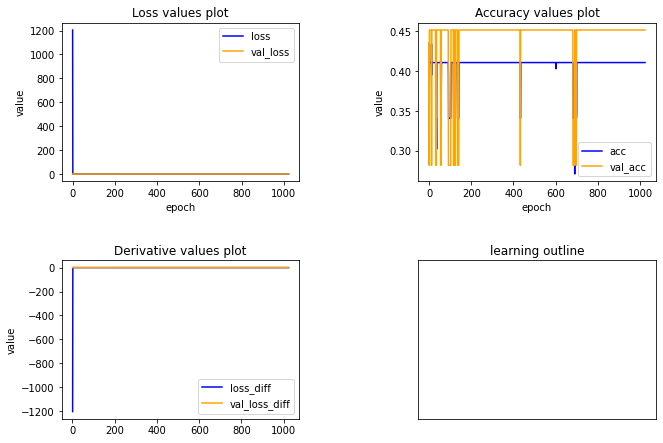

In [13]:
for each in histories:
  plot(each, learningDict)